# Cómputo Cuántico en la nube

## 1. Configuración

Se debe contar con las siguientes bibliotecas: 
```shell 
pip install matplotlib pylatexenc 
pip install qiskit qiskit-ibm-provider qiskit-ibm-runtime qiskit-aer 
``` 

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import qasm2
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
from qiskit_ibm_provider import IBMProvider, least_busy
import numpy  as np
import math

/tmp/ipykernel_7809/2397736641.py:7: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider, least_busy


In [2]:
# Argumentos para los diagramas
draw_kwargs = {
        "output": "mpl",        # matplotlib
        "cregbundle": False,    # separa los cables
        "initial_state": True,  # muestra |0>
        "idle_wires": False,    # no mostar cables sin utilizar
    "style": {
        "subfontsize": 9,       # tamaño
        "dpi": 600
    }
}

Crear una cuenta en: [IBM Quantum Platform](https://quantum.ibm.com/). Iniciar sesión en ir a Dashboard. 

![Screenshot from 2024-09-23 10-12-03.png](<attachment:Screenshot from 2024-09-23 10-12-03.png>)
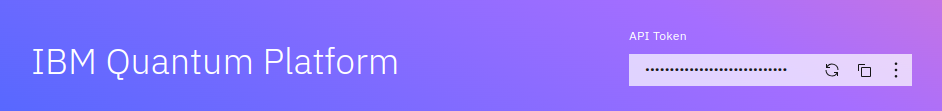

Copiar el API Token

Si es la primera vez que se ejecuta las siguientes líneas, el token se guarda en el disco duro en la dirección **$HOME/.qiskit/qiskit-ibm.json**. 

Solo debe ejecutarse una vez **QiskitRuntimeService.save_account()** para que se guarde el token. 

In [ ]:
API_token = ""
QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_token, overwrite=True)

Verificar que se tenga acceso a los servidores

In [3]:
provider = IBMProvider()

## 2. Compuertas y Circuitos Cuánticos

Para visualizar la acción de las compuertas cuánticas es conveniente utilizar un simulador de la 
esfera de Bloch [Bloch Sphere Simulator](https://bloch.kherb.io/).
Los circuitos cuánticos puede ser construidos interactivamente con la herramienta de IBM
[IBM Quantum Composer](https://quantum.ibm.com/composer).

### 2.1 Circuitos de 1 qubit

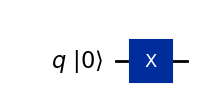

In [4]:
# Se inicia definiendo a los registros. Un registro cuántico como 
# q y un registro clásico como meas.
qreg_q = QuantumRegister(1, "q")
creg_c = ClassicalRegister(1, "meas")

# Creación de un circuito
qc = QuantumCircuit(qreg_q, creg_c)

# Compuerta X
qc.x(qreg_q[0])
qc.draw(**draw_kwargs)

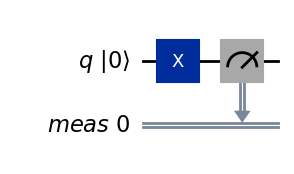

In [5]:
qc.measure(qreg_q[0], creg_c[0])
qc.draw(**draw_kwargs)

### 2.2 Simulación

In [6]:
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
print(counts)

{'1': 64}


In [7]:
print(qasm2.dumps(qc))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg meas[1];
x q[0];
measure q[0] -> meas[0];


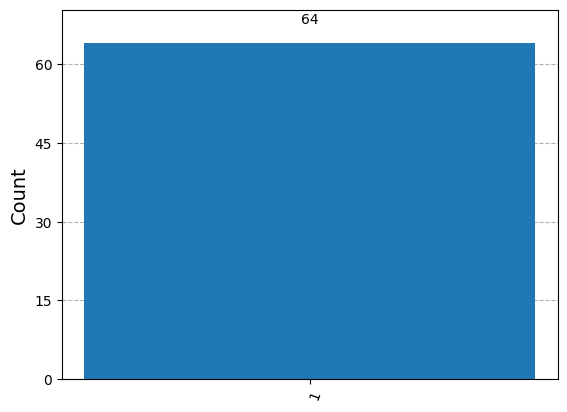

In [8]:
plot_histogram(counts)

### 2.3 Más de 1 qubit
Entrelazamiento cuántico

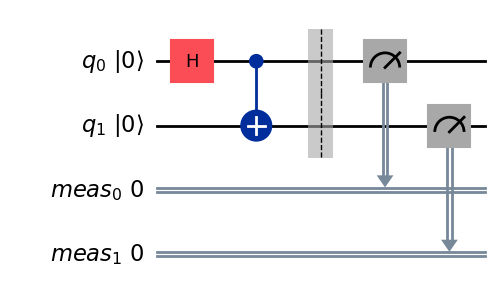

In [10]:
bell = QuantumCircuit(2)
bell.h(0)
#bell.x(1)
bell.cx(0, 1)
bell.measure_all()
bell.draw(**draw_kwargs)

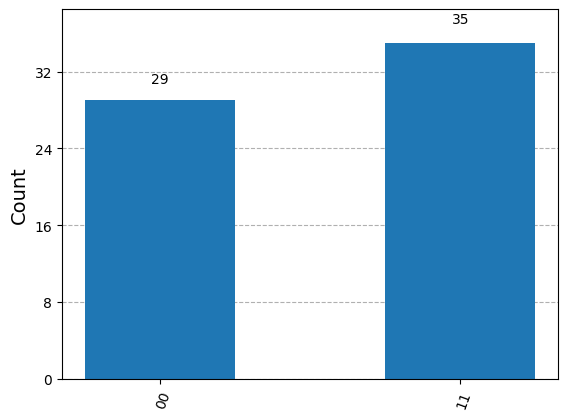

In [11]:
simulator = AerSimulator()
result = simulator.run(bell, shots = 64).result()
counts = result.get_counts(0)
plot_histogram(counts)

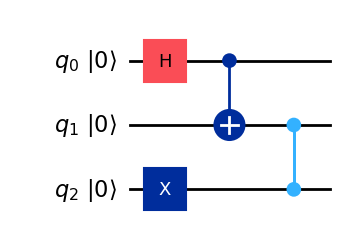

In [12]:
qc = QuantumCircuit(3)

qc.h(0)  
qc.cx(0, 1) 
qc.x(2)
qc.cz(1, 2) 
qc.draw(**draw_kwargs) 

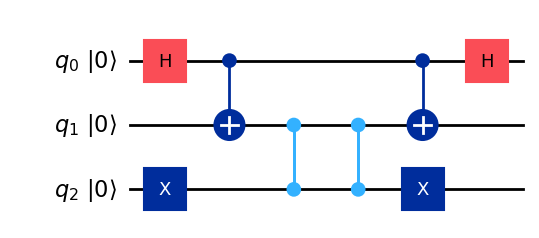

In [13]:
qc.cz(1, 2)
qc.x(2)  
qc.cx(0, 1)  
qc.h(0)
qc.draw(**draw_kwargs)  

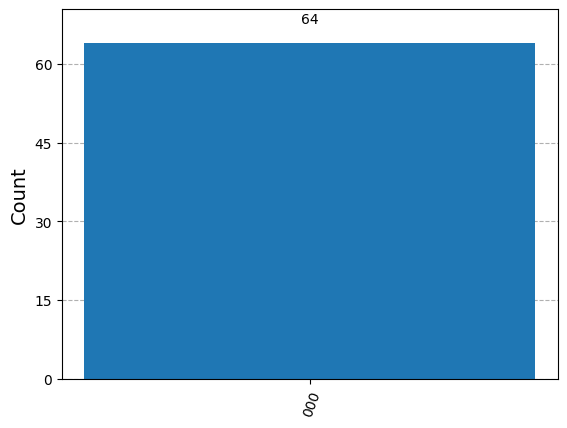

In [14]:
qc.measure_all()
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
plot_histogram(counts)

## 3. Computación cuántica en la nube

### 3.1 Servidores

In [15]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

Nombre del sistema           Número de Qubits
---------------------------------------------
[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_brisbane')>]
ibm_sherbrooke               127
ibm_kyiv                     127
ibm_brisbane                 127


### 3.2 Hardware cuántico

In [16]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))

In [17]:
print(device)

<IBMBackend('ibm_brisbane')>


[Computing resources](https://quantum.ibm.com/services/resources)

In [18]:
base, b = quantum_state = (-math.sqrt(3)/2, complex(0, 1/2))
norm = abs(base)**2 + abs(b)**2
print(norm)

0.9999999999999999


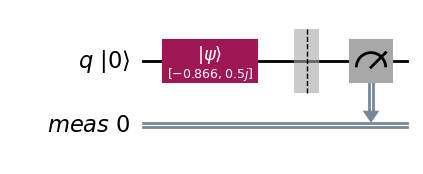

In [19]:
cqc = QuantumCircuit(1)
cqc.initialize(quantum_state, 0)
cqc.measure_all()
cqc.draw(**draw_kwargs)

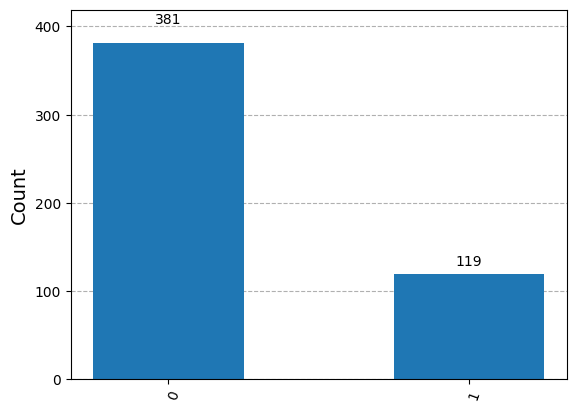

In [20]:
simulator = AerSimulator()
result = simulator.run(cqc, shots = 500).result() 
counts = result.get_counts(cqc)
plot_histogram(counts)
#plot_histogram([counts, counts1], legend=["a", "b"])

**Transpilation** es el proceso de rescribir una entrade de un circuito para que coincida con la topología específica de un dispositivo cuántico y/o optimizar la ejecución del circuito en los sistemas cuánticos con ruido. 

Esta operación sigue 6 pasos que pueden ser iterativos: 

- Optimización virtual del circuito 

- Descomposición a compuertas de 3 qubits 

- Posicionamiento de qubits físicos 

- Enrutamiento 

- Traducción a compuertas base 

- Optimización física del circuito 

In [21]:
quantum_hw = provider.get_backend("ibm_sherbrooke")
qc_transpiled = transpile(cqc, quantum_hw)
qc_transpiled.draw(style = "iqd")


global phase: 3π/2
                        ┌───────────┐┌────┐┌──────────┐┌────┐┌──────────┐ ░ ┌─┐
          q_0 -> 0 ─|0>─┤ Rz(-3π/2) ├┤ √X ├┤ Rz(4π/3) ├┤ √X ├┤ Rz(5π/2) ├─░─┤M├
                        └───────────┘└────┘└──────────┘└────┘└──────────┘ ░ └╥┘
    ancilla_0 -> 1 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_1 -> 2 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_2 -> 3 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_3 -> 4 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_4 -> 5 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_5 -> 6 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_6 -> 7 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_7 -> 8 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
    ancilla_8 -> 9 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
   ancilla_9 -> 10 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_10 -> 11 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_11 -> 12 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_12 -> 13 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_13 -> 14 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_14 -> 15 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_15 -> 16 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_16 -> 17 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_17 -> 18 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_18 -> 19 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_19 -> 20 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_20 -> 21 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_21 -> 22 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_22 -> 23 ──────────────────────────────────────────────────────────╫─
                                                                             ║ 
  ancilla_23 -> 24 ──────────────────────────────────────────

## 4. Algoritmo de Shor

In [23]:
import matplotlib.pyplot as plt

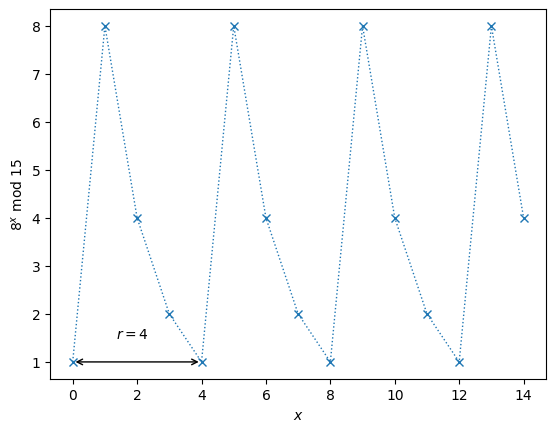

In [30]:
N = 15
base = 8

# valores
xvals = np.arange(N)
yvals = [np.mod(base**x, N) for x in xvals]

fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${base}^x$ mod ${N}$')
try: # encontrar el periodo cuando es 1
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('No ha periodo, a no tiene factores con N')

In [28]:
def fx_7mod15(a, power):
    U = QuantumCircuit(4)
    for i in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = "7 ^ %i mod 15"%(power)
    c_U = U.control()
    return c_U

In [31]:
def c_amod15(base, power):
    if base not in [2,4,7,8,11,13]:
        raise ValueError("'a' tiene que ser 2,4,7,8,11 o 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if base in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if base in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if base in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if base in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{base}^{power} mod 15"
    c_U = U.control()
    return c_U

In [32]:
def QFTi(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for k in range(j):
            if k != j:
                qc.cu(-np.pi/float(2**(j-k)), 0, 0, 0, k, j)
        qc.h(j)
    qc.name = "QFTi"
    return qc

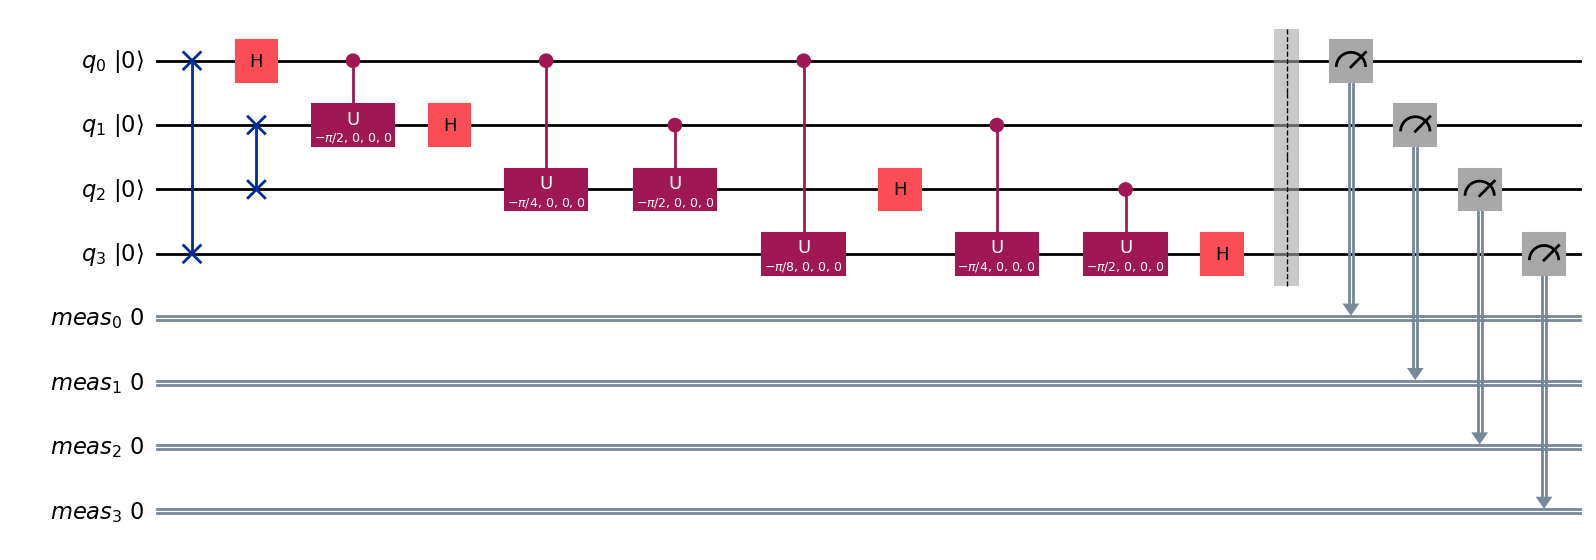

In [33]:
qc = QFTi(4)
qc.measure_all()
qc.draw(**draw_kwargs)

In [34]:
n_qubits = 4 #num qubits
base = 7
qc = QuantumCircuit(n_qubits+4, n_qubits)

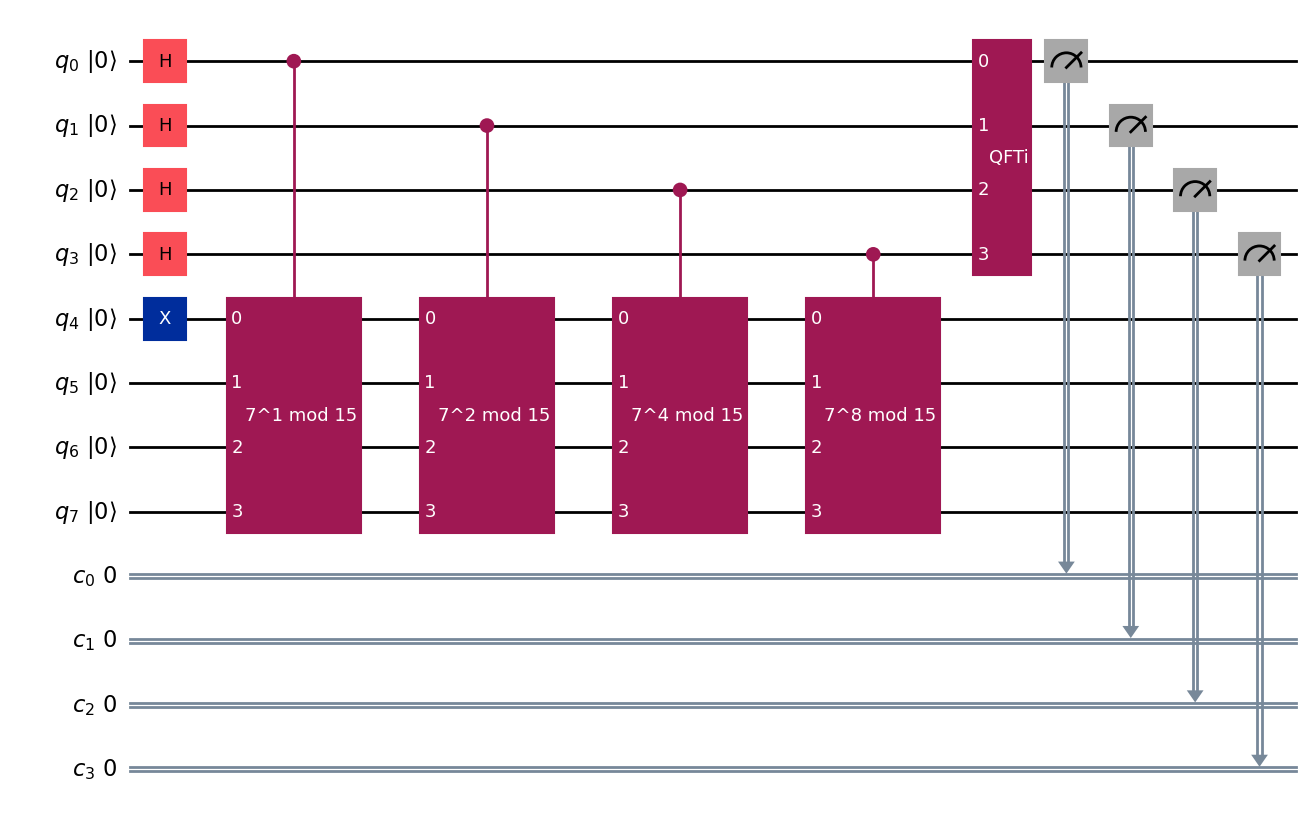

In [35]:
for q in range(n_qubits):
    qc.h(q)
qc.x(n_qubits)

for q in range(n_qubits):
    qc.append(c_amod15(base, 2**q),
             [q] + [i+n_qubits for i in range(4)])
qc.append(QFTi(n_qubits), range(n_qubits))
# qc.measure_all()
qc.measure(range(n_qubits), range(n_qubits))
qc.draw(**draw_kwargs)

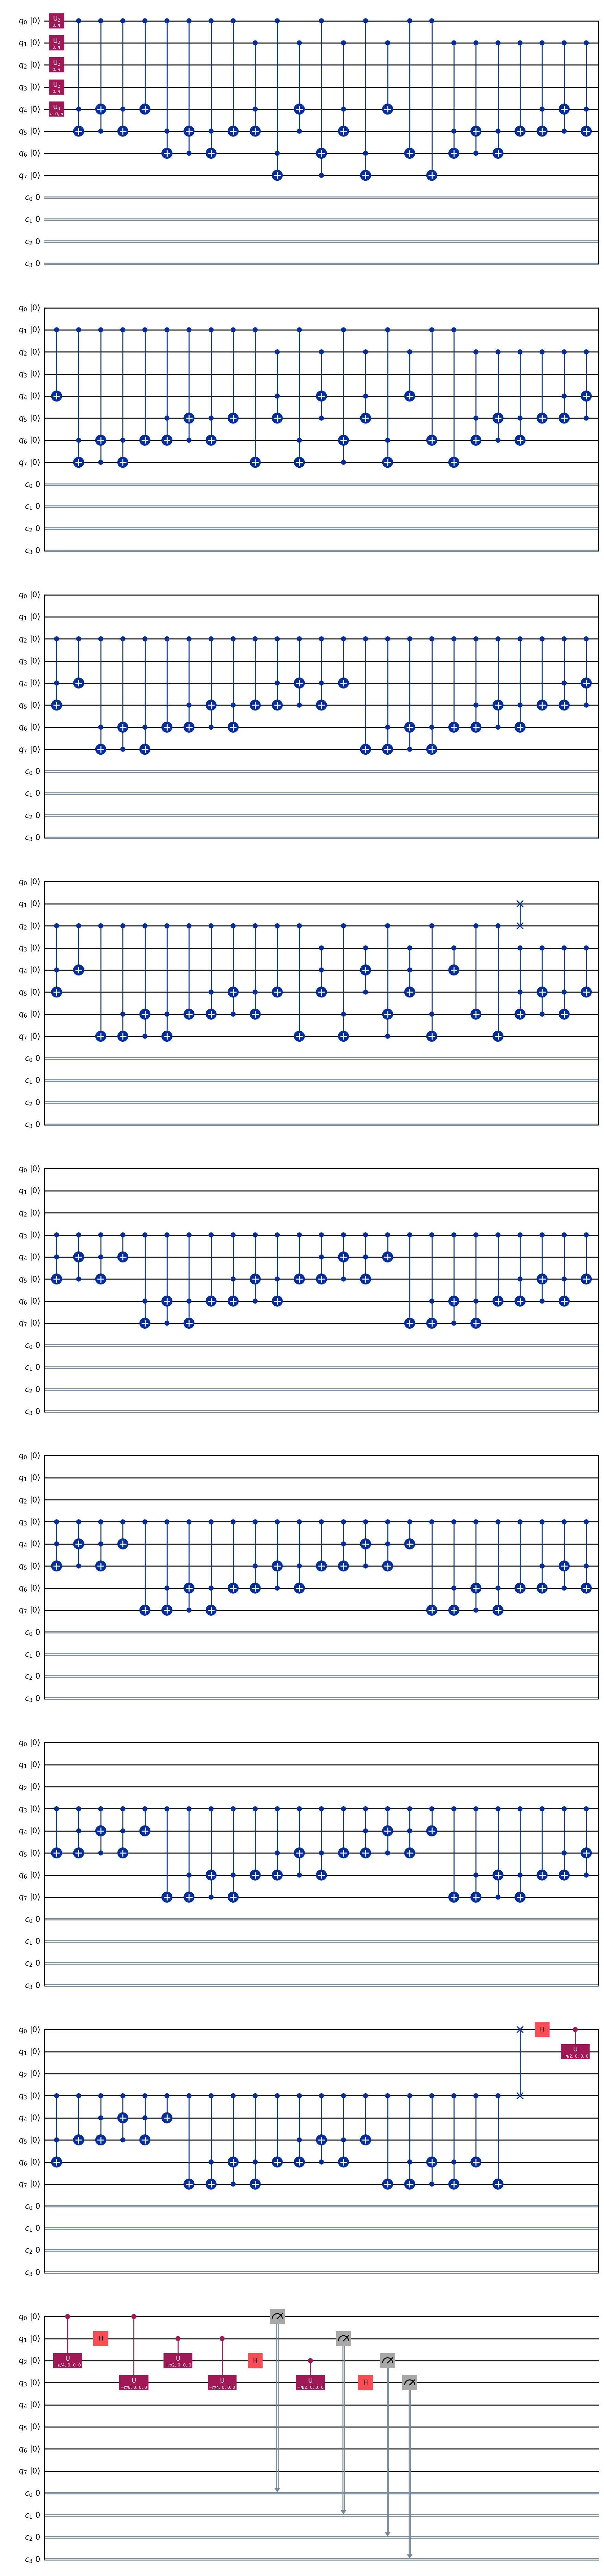

In [36]:
qc_dec = qc.decompose()
qc_dec.draw(**draw_kwargs)

Resultados: {'0100': 250, '0000': 237, '1000': 267, '1100': 270}


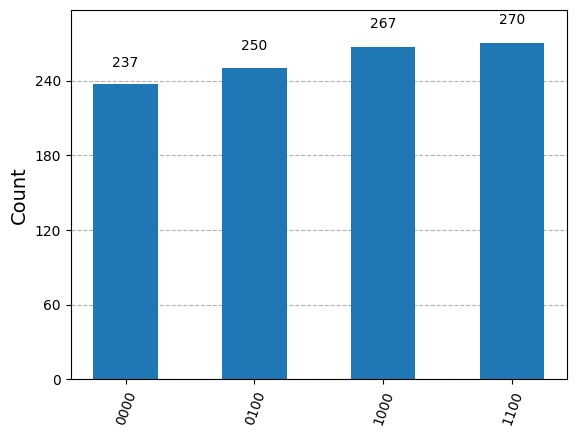

In [37]:
simulator = AerSimulator()
result = simulator.run(qc_dec, shots=1024).result()
counts = result.get_counts(0)
print("Resultados:", counts)
plot_histogram(counts)

In [38]:
from fractions import Fraction

In [39]:
frac = Fraction(12/16)
print(frac)
period = frac.denominator

3/4


In [40]:
def gcd(a, b):
    while b != 0:
        tmp = a % b
        a = b
        b = tmp
    return a

In [41]:
print("base: ", base, "N: ", N, "period: ", period)
print("factor: ",gcd(base**(period//2) +1, N))
print("factor: ",gcd(base**(period//2) -1, N))

base:  7 N:  15 period:  4
factor:  5
factor:  3


### 4.1 Shor en hardware cuántico

In [ ]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

In [ ]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))
print(device)

In [54]:
quantum_hw = provider.get_backend("ibm_brisbane")
qc_transpiled = transpile(qc_dec, quantum_hw)

In [ ]:
qc_transpiled.draw(style = "iqd")

In [55]:
job = quantum_hw.run(qc_transpiled, shots=1024)

In [56]:
job.job_id()

'cvynbzzz9es0008e7qy0'

In [57]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [ ]:
job_result = job.result()  # bloquea hasta que se haya completado el trabajo
print("El trabajo termino con un estado: {}".format(job_result))

### 4.2 Base 4

ID del resultado de Shor para factorizar 15 con base 4  con 1024 intentos: 'cvyn6es6xzjg0084hkag'

In [42]:
service = QiskitRuntimeService()
job = service.job('cvyn6es6xzjg0084hkag')
job.status()

<JobStatus.DONE: 'job has successfully run'>

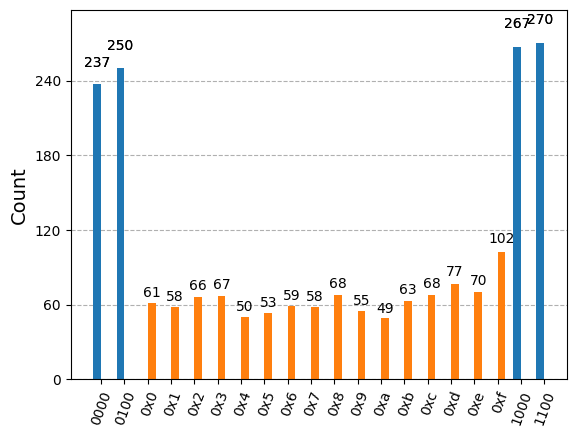

In [43]:
data = job.result().data()
countshw = data['counts']
plot_histogram([counts, countshw])

In [44]:
print(counts)
print(countshw)
bin_dict = {bin(int(key, 16))[2:].zfill(4): value for key, value in countshw.items()}

print(bin_dict)

{'0100': 250, '0000': 237, '1000': 267, '1100': 270}
{'0x7': 58, '0x4': 50, '0xe': 70, '0x9': 55, '0xb': 63, '0x1': 58, '0x5': 53, '0x8': 68, '0x3': 67, '0xa': 49, '0xd': 77, '0x6': 59, '0x2': 66, '0xc': 68, '0xf': 102, '0x0': 61}
{'0111': 58, '0100': 50, '1110': 70, '1001': 55, '1011': 63, '0001': 58, '0101': 53, '1000': 68, '0011': 67, '1010': 49, '1101': 77, '0110': 59, '0010': 66, '1100': 68, '1111': 102, '0000': 61}


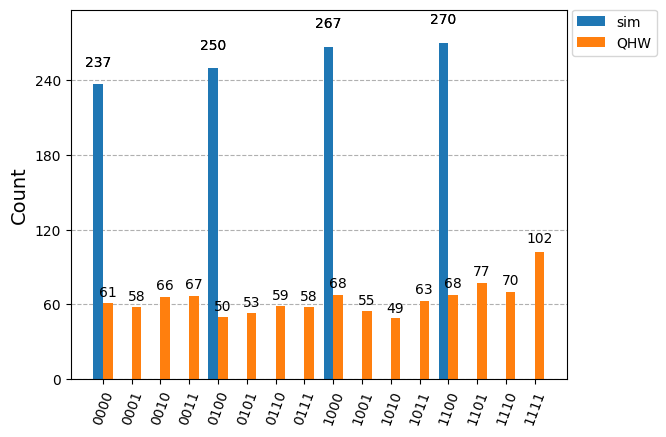

In [45]:
plot_histogram([counts, bin_dict], legend=["sim", "QHW"])

### 4.3 Base 7

ID del resultado de Shor para factorizar 15 con base 4  con 1024 intentos: 'cvynbzzz9es0008e7qy0'